In [1]:
%pwd
%cd /app

import dac
from audiotools import AudioSignal

import torch

import numpy as np
import matplotlib.pyplot as plt
# import soundfile as sf
# import IPython.display as ipd

/app


In [2]:
torch.cuda.device_count()
print(f'memeory on cuda 0 is  {torch.cuda.get_device_properties(0).total_memory/1e9}')
print(f'memeory on cuda 1 is  { torch.cuda.get_device_properties(1).total_memory/1e9}')
device = torch.device("cuda:0") # if the docker was started with --gpus all, then can choose here.
device

memeory on cuda 0 is  25.216745472
memeory on cuda 1 is  25.214386176


device(type='cuda', index=0)

In [3]:
model_path = "codecweights/weights_44_8.pth"
#model_path = "codecweights/weights_16_8.pth"
model = dac.DAC.load(model_path)
model.to(device); #wanna see the model? remove the semicolon

In [4]:
datadir="/scratch/lonce/koraySegmentedSoundData/split_1sec_44k"

N_QUANTIZERS = 9  ## SEEMS TO HAVE NO EFFECT - I guess because it is a property of the pretrained model?

snd1_wav ='/file0791_segment35.wav' 

#1) LOAD A SOUND
snd1 = AudioSignal(datadir + snd1_wav) # 2-second sound at 16kHz
#snd1 = snd1[0,0,: int(snd1.shape[2]/CORTADOFACTURA)] # cortado, otherwise the computation will bust memory

#2) PUT IT ON THE GPU
snd1.to(model.device)
#3) PREPROCESS (make sure sr agrees with model, i guess)
snd1_x = model.preprocess(snd1.audio_data, snd1.sample_rate)
#4) ENCODE TO Z, C, and L
snd1_z, snd1_codes, snd1_latents, _, _ = model.encode(snd1_x, N_QUANTIZERS) #model.encode(snd1_x, 4)

In [5]:
print(f'snd1_latents shape is: {snd1_latents.shape}')

snd1_latents shape is: torch.Size([1, 72, 87])


In [6]:
ydim=snd1_latents.shape[1]
xdim=snd1_latents.shape[2]

In [7]:

import os
import random
import wave
import numpy as np

# def anal(wav_data):
#     # Dummy implementation of the analysis function
#     # Replace with your actual analysis logic
#     return np.array([np.mean(wav_data), np.std(wav_data)])

def read_random_wav_files(folder, n):
    # List all .wav files in the folder
    files = [f for f in os.listdir(folder) if f.endswith('.wav')]
    
    # Select n random files
    random_files = random.sample(files, min(n, len(files)))

    # Array to store the concatenated results
    results = []

    for file in random_files:
        # Read the wav file
        audio_data = AudioSignal(datadir + snd1_wav)
        audio_data.to(model.device)
        audio_data_x = model.preprocess(snd1.audio_data, snd1.sample_rate)
        _, _, audio_data_latents, _, _ = model.encode(audio_data_x) 

        results.append(audio_data_latents)
        
    return torch.stack(results)
    # # Concatenate all results into a tensor
    # result_tensor = np.vstack(results)

    # return result_tensor

# # Example usage
# folder_path = '/path/to/your/wav/files'
# n = 5  # Number of random files to read
# result_tensor = read_random_wav_files(folder_path, n)
# print(result_tensor)


In [8]:
result_tensor = read_random_wav_files(datadir, 4)
print(f'result_tensor shape is: {result_tensor.shape}')

result_tensor shape is: torch.Size([4, 1, 72, 87])


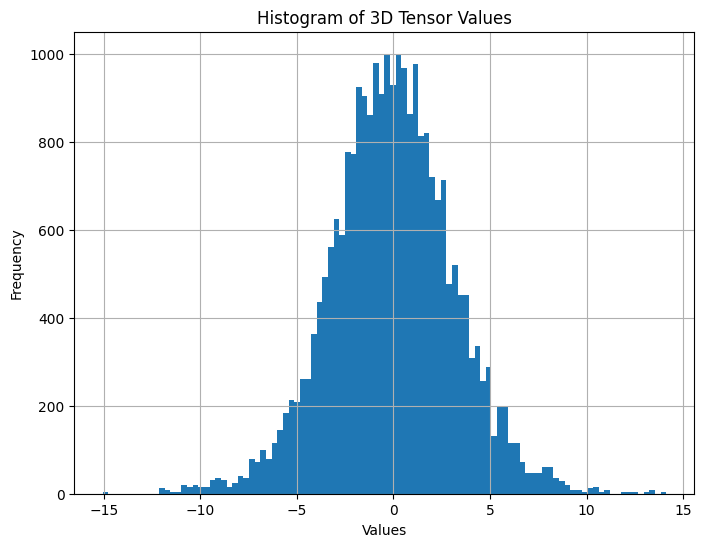

In [9]:
# Flatten the tensor to 1D
numpy_array = result_tensor.cpu().detach().numpy().flatten()

# Define the number of bins
num_bins = 100

# Create a histogram using NumPy to compute bin edges and counts
hist, bin_edges = np.histogram(numpy_array, bins=num_bins)

# Compute the average values for each bin
bin_avg_values = []
for i in range(num_bins):
    mask = np.logical_and(numpy_array >= bin_edges[i], numpy_array <= bin_edges[i + 1])
    bin_avg = np.mean(numpy_array[mask]) if np.sum(mask) > 0 else 0
    bin_avg_values.append(bin_avg)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(numpy_array, bins=num_bins)
plt.title('Histogram of 3D Tensor Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Calculate positions for the labels spread across the horizontal width of the image
# label_positionsx = np.linspace(-num_bins/2, num_bins/2, num_bins)
# label_positionsy = linspace_v(0, np.max(hist), num_bins)

#print(label_positions)
# Annotate the plot with average values, rotating labels 90 degrees clockwise
for i in range(num_bins):
    label = f'{bin_avg_values[i]:.2f}'

plt.grid(True)
plt.show()